# Fitting SVG signal

In this notebook I will take a random sample of points from the SVG smoothed signal (created in Sunspot Data Plotting) and see if the Gaussian process can (essentially) fill in the rest of the points.

For this I will be using the ***qusi-periodic kernel function***, given by:

$$ k_{i,j} = A^2 \exp{\left[-\frac{(x_i-x_j)^2}{2 l_1^2} - \frac{\sin^2}{l^2_2}{\left(\frac{\pi (x_i - x_j)}{P} \right)} \right]} + \sigma^2 \delta_{ij}$$

A list of kernel functions for PyMC3 can be found at https://docs.pymc.io/en/v3/api/gp/cov.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy as sp
import arviz as az
import theano.tensor as tt

In [2]:
df = pd.read_csv('Data/SVG_poly1.csv') # importing data for SVG polyorder = 1
X = ((df.Year).values).reshape(-1,1)
y = (df.Sunspot_Number).values
yerr = np.zeros(len(X)) 

In [3]:
df.head()

,Unnamed: 0,Year,Sunspot_Number
0,0,1818.001,34.566570
1,1,1818.004,34.546053
2,2,1818.007,34.525535
3,3,1818.010,34.505017
4,4,1818.012,34.484499


In [4]:
rng = np.random.RandomState(1) # random selection of points
training_indices = rng.choice(np.arange(y.size), size=200, replace=False)

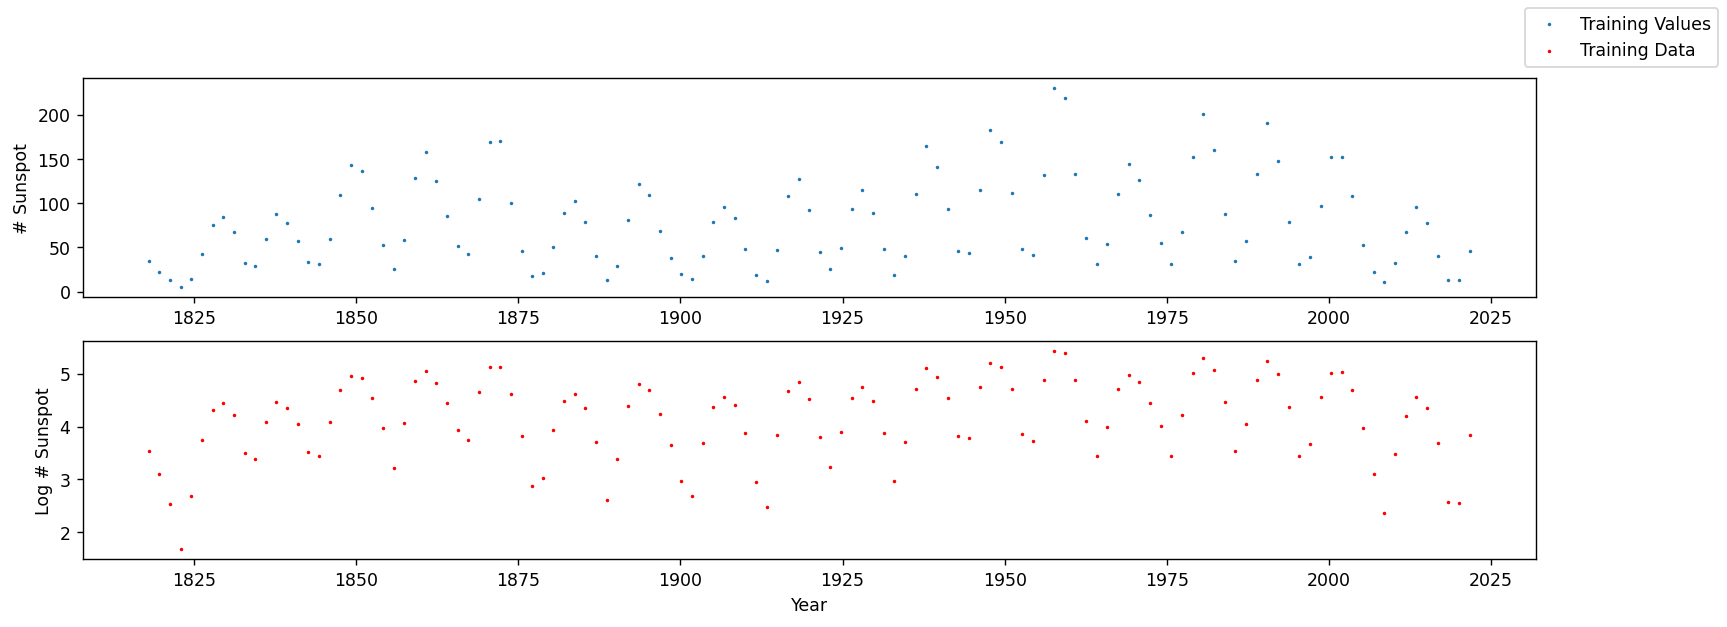

In [5]:
training_values = X[::600], y[::600]
# Note: changed from using random values to using
# every 600 values --> want to get the best fitting 

training_data = training_values[0], np.log(training_values[1])  
# take logs to obtain positive definite values
X_train = training_data[0]
y_train = training_data[1]

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])

ax[0].scatter(training_values[0], training_values[1], label='Training Values', s=1)
ax[0].set_ylabel("# Sunspot")
ax[1].scatter(training_data[0], training_data[1], label='Training Data', s=1, color='red')
ax[1].set_ylabel("Log # Sunspot")
ax[1].set_xlabel('Year')
fig.legend();

Here we are taking a sample of points from our data (which contains over 70,000 datapoints). The training data represents most of the shape of the distribution, so we will observe how well it can be modelled using a Gaussian process.

PyMC3 doesn't contain the quasi-periodic kernel, but it *does* contain a **periodic kernel** as well as a **squared exponential kernel**, which we can multiply togehter to arrive at our desired kernel.

In [6]:
# Define Sinusoidal Mean Function
class SinusoidalMean(pm.gp.mean.Mean):
    def __init__(self, amplitude):
        super().__init__()
        self.amplitude = amplitude
    
    def __call__(self, x):
        return self.amplitude * tt.sin(x[:, 0] * np.pi / period + phase)**2 + offset

# Define the Gaussian Process
with pm.Model() as model:
    
    
    # Define the phase of the sinusoidal mean
    phase = pm.Beta('phase', 2, 2)
    
    # Define the amplitude of the sinusoidal mean
    amplitude = pm.Gamma('amplitude', 2, 2)
    
    # Define the offset of the sinusoidal mean
    offset = pm.Gamma('offset', 2, 2)
    
    # Define the `Period' as a normal distribtion with mean = 11 years
    period = 11
    
    # Define the `length scale 1' of the periodic kernel as a normal distribution with mean = 1 year
    length_scale1 = pm.Normal('Length Scale 1', 1, 1)  
    
    # Define the `length_scale 2' of the squared-exponential kernel as a normal distribution with mean = 9 years
    length_scale2 = pm.Normal('Length Scale 2', 9, 4)
    
    # Define the `Standard deviation' as a beta function
    sigma = pm.Beta('$\sigma$', 2, 2)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1)
    
    # Define the squared-exponential kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2)
    
    # Define the quasi-periodic kernel
    cov_qp = cov_SE * cov_periodic 
    
    sinusoidal_mean = SinusoidalMean(amplitude)
    
    gp = pm.gp.Marginal(cov_func=cov_qp, mean_func=sinusoidal_mean)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, Length Scale 2, Length Scale 1, offset, amplitude, phase]


/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 253 seconds.
The acceptance probability does not match the target. It is 0.7019143241137488, but should be close to 0.8. Try to increase the number of tuning steps.


The above code required a lot of trial and error to see at which points the priors converge to their optimal values, and continued readjustment of priors eventually lead to the values we have below.

**Update:** I have created a custom mean function using *theano*. This mean function is sinusoidal, as opposed to the constant one which was being used previously. I have done this because I don't want my GP to tend to a constand value when it gets too far from the previous data point, as we expect the solar cycle to retain its general sinusoidal shape.

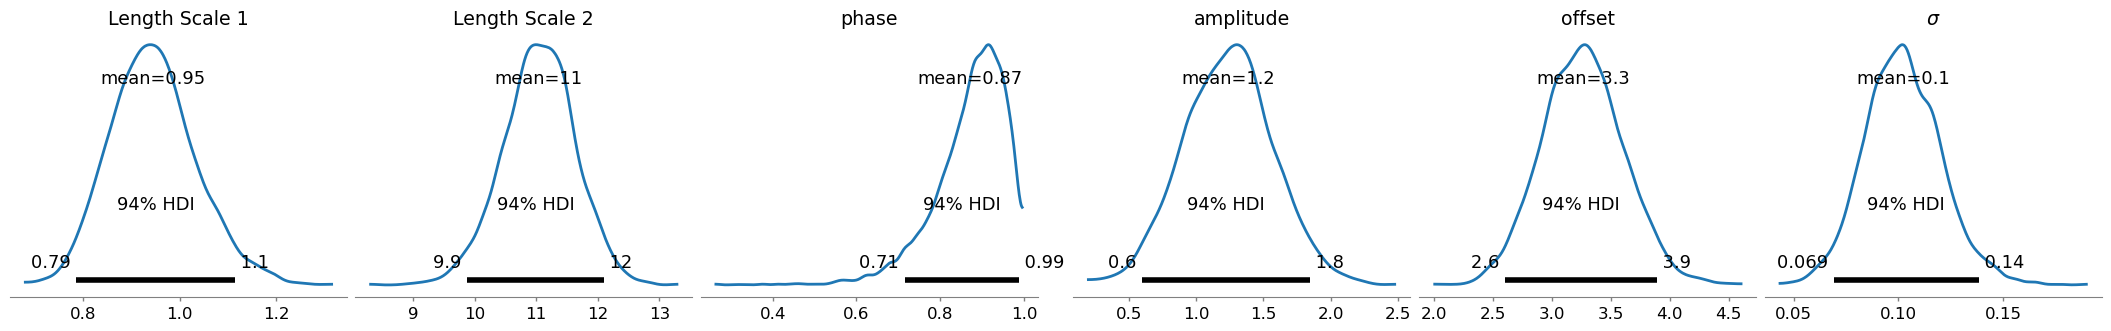

In [7]:
az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12, grid=(1,6));
#plt.savefig('gp post.png'); 

#### Comment on plot:

For the latest run-through I have set a separate parameter for the period of the sinusoidal mean (as opposed to the 11 year period previously attempted). As we can see from the posteriors, this parameter has 'messed up' the smooth distributions we had before, and the value for period has many different peaks. 

I still believe that the correct period in the sinusoidal mean should be ~ 11 years, but for the posterior of *period1* shows something very different and needs exploring further.

In [8]:
X_new = np.linspace(1800, 2055, 500)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_new"])#

/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


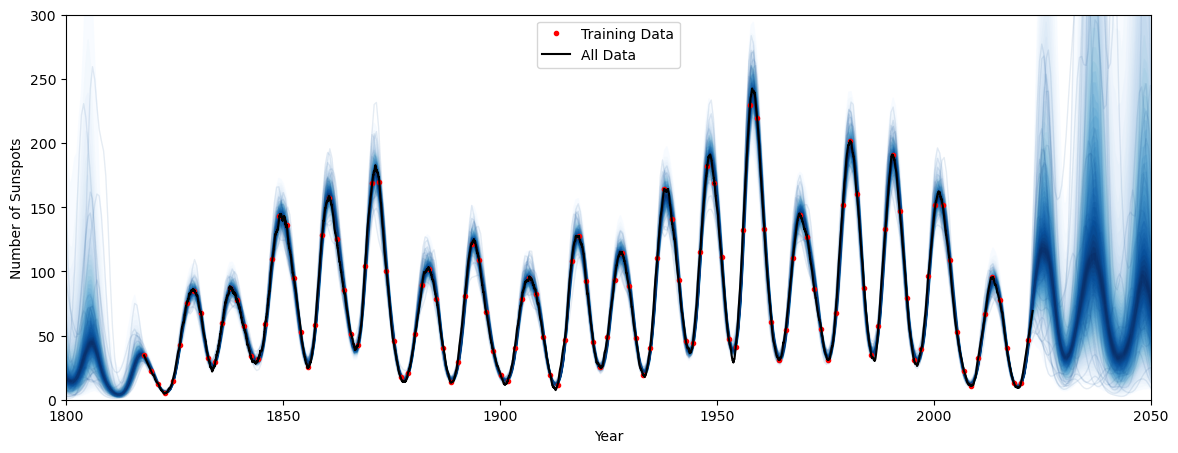

In [9]:
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(14, 5))
ax = fig.gca()
plot_gp_dist(ax, np.exp(ppc['f_new']), X_new, palette="Blues")
# np.exp() to return log value to normal value

# plot original data and GP
plt.plot(training_values[0], training_values[1], "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(X, y, color="black", label="All Data")
plt.xlabel("Year")
plt.ylabel('Number of Sunspots')
plt.xlim(1800,2050)
plt.ylim(0,300)
plt.legend();
#plt.savefig('GD prediction');

#### Comment on plot:

Here we have used a ***quasi-periodic kernel*** consisting of only 200 data points. The GP does a very good job of modelling the data given the sparsity of data, however there is a recurrent issue with our parameter *length_scale1*, which is far too small and refuses to converge on anything else. This results in new predictions which do not show the same periodic behaivour, as the knowledge of the model essentially dies after that time.

**Edit**: Previously the GP was done using the 'training_values', but to ensure positive definiteness I have first taken the logarithm of the y-values, performed the GP, and then returned them back to standard sunspot number. As a result, the values for $A$, $\mu$ and $\sigma$ are all *logarithmic* values. This has improved the predictions made by the GP, as all predictions are plausible (as there are no negative sunspot numbers predicted).

**Edit 2**: Sinusoidal mean allows the future predictions to look more in line with our expectations, but we must not ignore the fact that these future predictions are simply the mean function. Therefore, we could argue that the GP is unable to make any reasonable predictions.


# Predicting validation dataset

## Data Preprocessing

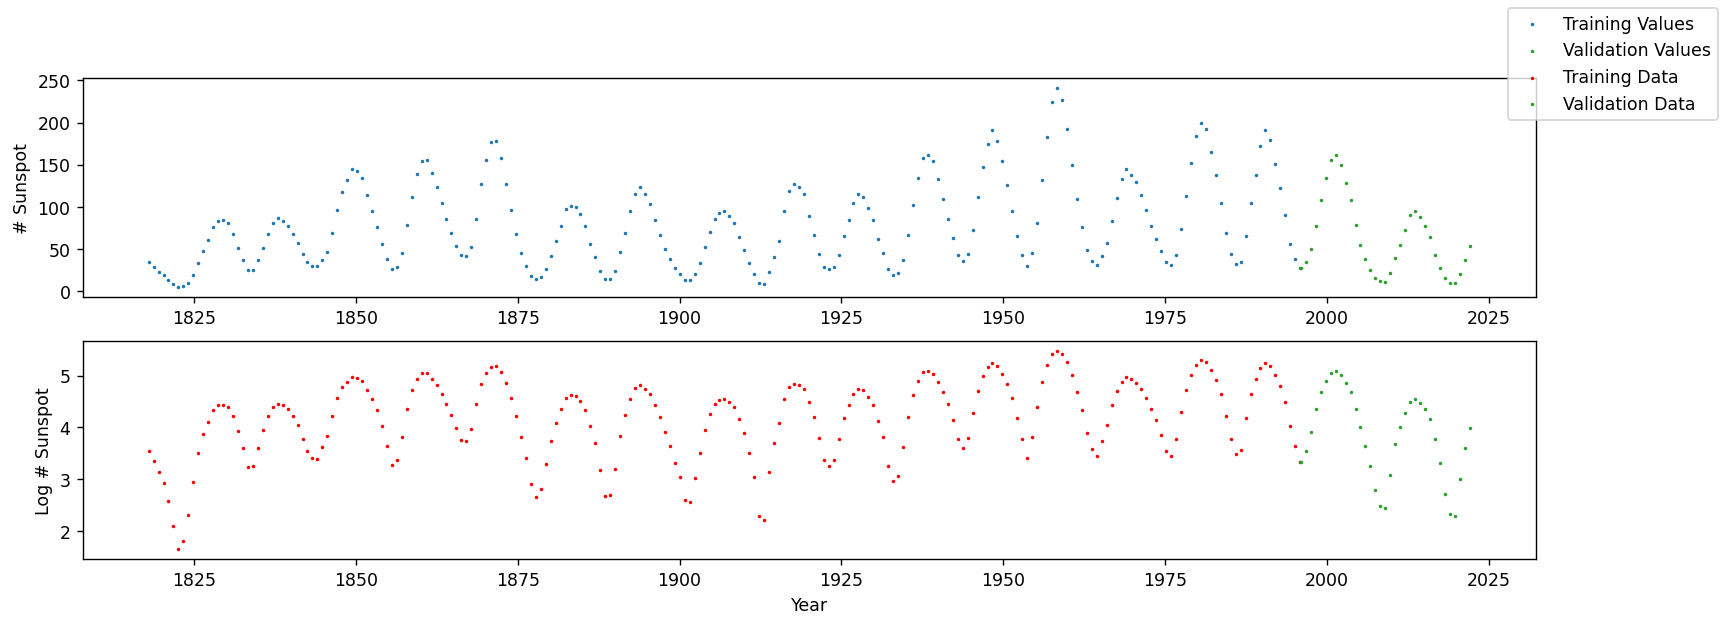

In [10]:
limit = 65000 # training with the first 70k datapoints
skips = 280 # 1 data point per 10 luna cycle
all_data = df.iloc[:70000]
train_data = df.iloc[:limit:skips] 
validation_data = df.iloc[limit::skips]

training_values = (train_data.Year.values).reshape(-1,1), train_data.Sunspot_Number.values
validation_values = (validation_data.Year.values).reshape(-1,1), validation_data.Sunspot_Number.values

training_data = training_values[0], np.log(training_values[1]) 
validation_data = validation_values[0], np.log(validation_values[1])

# take logs to obtain positive definite values
X_train = training_data[0]
y_train = training_data[1]

fig, ax = plt.subplots(2, dpi=125, figsize=[15,5])

ax[0].scatter(training_values[0], training_values[1], label='Training Values', s=1)
ax[0].scatter(validation_values[0], validation_values[1], label='Validation Values', s=1, color='tab:green')
ax[0].set_ylabel("# Sunspot")
ax[1].scatter(training_data[0], training_data[1], label='Training Data', s=1, color='red')
ax[1].scatter(validation_data[0], validation_data[1], label='Validation Data', s=1, color='tab:green')
ax[1].set_ylabel("Log # Sunspot")
ax[1].set_xlabel('Year')
fig.legend();

## GP Regression

In [19]:
# Define Sinusoidal Mean Function
class SinusoidalMean(pm.gp.mean.Mean):
    def __init__(self, amplitude):
        super().__init__()
        self.amplitude = amplitude
    
    def __call__(self, x):
        return self.amplitude * tt.sin(x[:, 0] * np.pi / period + phase)**2 + offset

# Define the Gaussian Process
with pm.Model() as model:
    
    # Define the phase of the sinusoidal mean
    phase = 0.87 #pm.Beta('phase', 2, 2)
    
    # Define the amplitude of the sinusoidal mean
    amplitude = pm.Gamma('amplitude', 2, 2)
    
    # Define the amplitude of the gaussian process
    A = pm.Gamma('A', 2, 2)
    
    # Define the offset of the sinusoidal mean
    offset = 3.3 #pm.Gamma('offset', 2, 2)
    
    # Define the `Period' as a normal distribtion with mean = 11 years
    period = pm.Normal('period', 11, 1)
    
    # Define the `length scale 1' of the periodic kernel as a normal distribution with mean = 1 year
    length_scale1 = 0.95 #pm.Normal('Length Scale 1', 1, 1)  
    
    # Define the `length_scale 2' of the squared-exponential kernel as a normal distribution with mean = 9 years
    length_scale2 = 11 #pm.Normal('Length Scale 2', 9, 4)
    
    # Define the `Standard deviation' as a beta function
    sigma = 0.1 #pm.Beta('$\sigma$', 2, 2)
    
    # Define the periodic kernel
    cov_periodic = pm.gp.cov.Periodic(1, period=period, ls=length_scale1)
    
    # Define the squared-exponential kernel
    cov_SE = pm.gp.cov.ExpQuad(1, ls=length_scale2)
    
    # Define the quasi-periodic kernel
    cov_qp = A**2 * cov_SE * cov_periodic 
    
    sinusoidal_mean = SinusoidalMean(amplitude)
    
    gp = pm.gp.Marginal(cov_func=cov_qp, mean_func=sinusoidal_mean)  # implementation of the sum of a GP prior and noise

    y_ = gp.marginal_likelihood("y", X=X_train, y=y_train, noise=sigma)

    tr = pm.sample(return_inferencedata=True) # finds local maximimum 'a posteriori point' given a model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [period, A, amplitude]


/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1181 seconds.
The acceptance probability does not match the target. It is 0.8847028296517544, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not ma

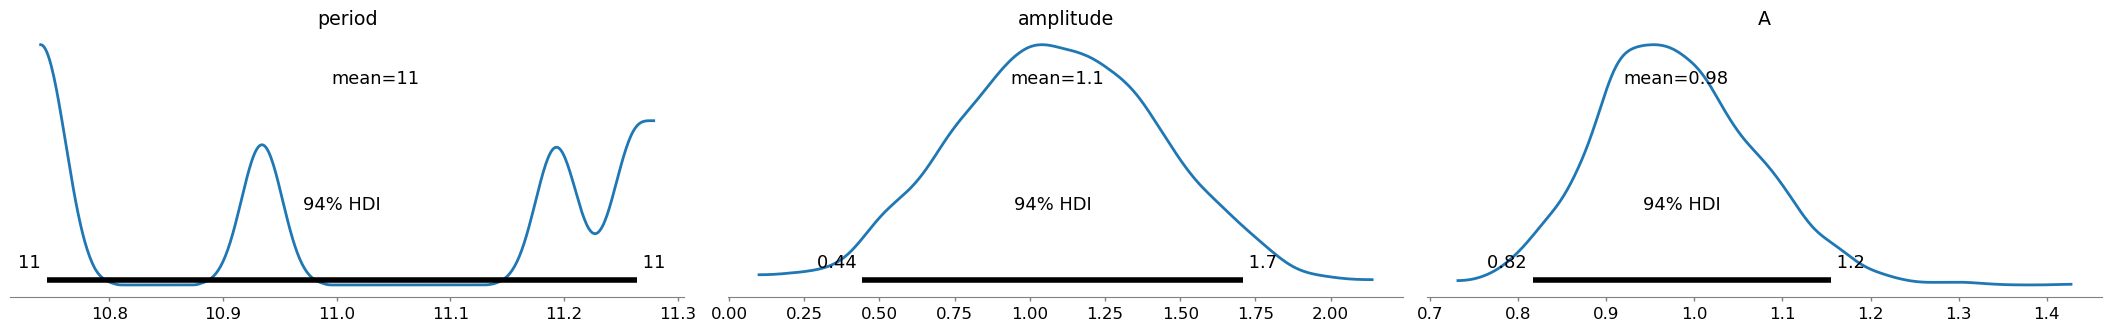

In [21]:
az.plot_posterior(tr, linewidth=2, c='tab:blue', figsize=(21,3.2), textsize=12, grid=(1,3));
#plt.savefig('gp post.png'); 

In [22]:
X_new = np.linspace(1818, 2025, 500)[:, None]
with model:
    fnew = gp.conditional("f_new", Xnew=X_new)

with model:
    ppc = pm.sample_posterior_predictive(tr, samples=1000, var_names=["f_new"])#

/opt/anaconda3/envs/mlp/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


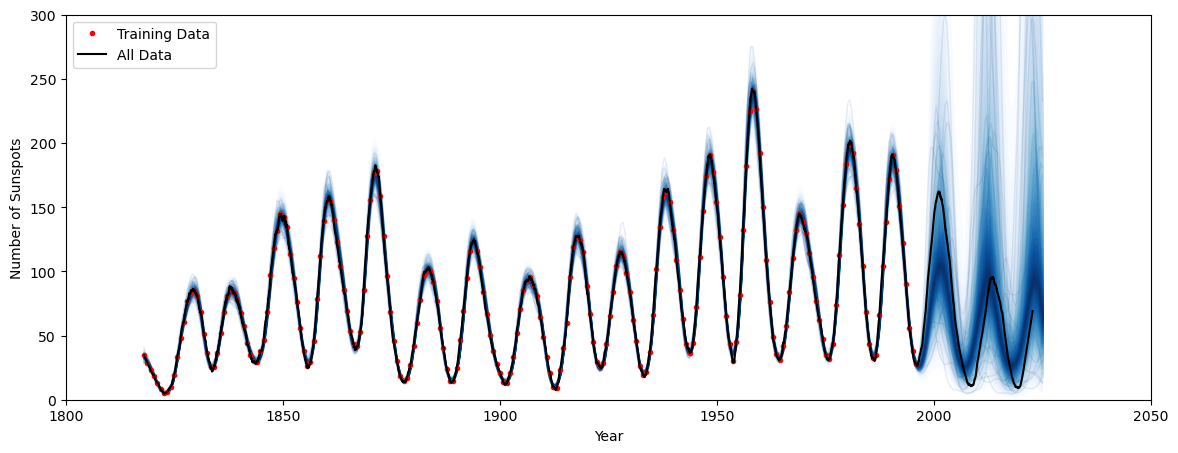

In [23]:
from pymc3.gp.util import plot_gp_dist

# draw plot
fig = plt.figure(figsize=(14, 5))
ax = fig.gca()
plot_gp_dist(ax, np.exp(ppc['f_new']), X_new, palette="Blues")
# np.exp() to return log value to normal value

# plot original data and GP
plt.plot(training_values[0], training_values[1], "or", ms=3, alpha=1.0, label="Training Data")
plt.plot(X, y, color="black", label="All Data")
#plt.plot(2009.635*np.ones(5), np.linspace(0,400,5), 'g--', label='End of training')
plt.xlabel("Year")
plt.ylabel('Number of Sunspots')
plt.xlim(1800,2050)
plt.ylim(0,300)
plt.legend();
#plt.savefig('GD prediction');

### Comment on plot:

Here we have performed the same GP as before, but now we have given the model 70,000 training values, and we ask it to predict the final few thousand points.

As we can see from the blue GP after we have finished training, the GP is unable to correctly predict what the values would be for sunspot number, the mode is smaller than the actual sunspot number recoreded. This seems to come from the problem with the mean function, as the mean's amplitude is still far too small.

**Edit**: For the latest run, I have used the parameters from the initial GP which takes all the data into account (**this is cheating**), just to see how well the GP performs. The figure above shows predictions which are generally closer to the actual values, however as we can see from the sampling there is still a huge uncertainty as to what the amplitude of the cycles are.